In [1]:
import imp
import os
import cv2
import pdb
import glob
import pandas as pd
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
# from torch.nn.functional import InterpolationMode
import torchvision.models as models

In [2]:
gloss_df_path = "data_validation/processed_gloss.csv"
gloss_df = pd.read_csv(gloss_df_path)
gloss_df.dropna(inplace=True)

In [3]:
gloss_df.head()

,gloss,glossStart,glossEnd,fileName,sentenceID
0,MƏN,9.0,24.0,2022-07-18 16-41-51.mp4,70
1,EV,29.0,41.0,2022-07-18 16-41-51.mp4,70
2,YANMAQ,46.0,102.0,2022-07-18 16-41-51.mp4,70
3,EV,30.0,41.0,2022-07-20 14-09-03.mp4,70
4,YANMAQ,44.0,74.0,2022-07-20 14-09-03.mp4,70


In [4]:
gloss_df['glossRange'] = gloss_df['glossEnd'] - gloss_df['glossStart']
gloss_df.head()

,gloss,glossStart,glossEnd,fileName,sentenceID,glossRange
0,MƏN,9.0,24.0,2022-07-18 16-41-51.mp4,70,15.0
1,EV,29.0,41.0,2022-07-18 16-41-51.mp4,70,12.0
2,YANMAQ,46.0,102.0,2022-07-18 16-41-51.mp4,70,56.0
3,EV,30.0,41.0,2022-07-20 14-09-03.mp4,70,11.0
4,YANMAQ,44.0,74.0,2022-07-20 14-09-03.mp4,70,30.0


In [5]:
gloss_df.glossRange.mean()

21.5597629239381

In [6]:
def img_resize(img_path, dims=(256, 256)):
    img = cv2.imread(img_path)
    img = cv2.resize(img, dsize=dims)

    return img

In [7]:
gloss_df[pd.isnull(gloss_df['glossStart'])]

,gloss,glossStart,glossEnd,fileName,sentenceID,glossRange


In [8]:
num_classes = len(gloss_df.gloss.unique())
num_classes

234

In [9]:
from torchvision.models import efficientnet_b6, EfficientNet_B6_Weights
from torchvision import transforms

In [10]:
# Image normalization transforms.
def normalize_transform(pretrained):
    if pretrained: # Normalization for pre-trained weights.
        normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
            )
    else: # Normalization when training from scratch.
        normalize = transforms.Normalize(
            mean=[0.5, 0.5, 0.5],
            std=[0.5, 0.5, 0.5]
        )
    return normalize
    
def get_train_transform(dims, pretrained):
    train_transform = transforms.Compose([
        transforms.Resize(dims),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
        transforms.ToTensor(),
        normalize_transform(pretrained)
    ])
    return train_transform

def get_valid_transform(IMAGE_SIZE, pretrained):
    valid_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        normalize_transform(pretrained)
    ])
    return valid_transform


In [52]:
weights = EfficientNet_B6_Weights.IMAGENET1K_V1
model = efficientnet_b6(weights=weights)

In [53]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 56, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(56, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(56, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=56, bias=False)
            (1): BatchNorm2d(56, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(56, 14, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(14, 56, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [54]:
my_model = nn.Sequential(*list(model.children())[:-1])

In [13]:
preprocess = weights.transforms()

In [57]:
preprocess

ImageClassification(
    crop_size=[528]
    resize_size=[528]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [15]:
import cv2
import matplotlib.pyplot as plt
import PIL

In [16]:
from typing import Optional, Tuple

In [17]:
# class ImageClassification(nn.Module):
#     def __init__(
#         self,
#         *,
#         crop_size: int,
#         resize_size: int = 256,
#         mean: Tuple[float, ...] = (0.485, 0.456, 0.406),
#         std: Tuple[float, ...] = (0.229, 0.224, 0.225),
#         # interpolation: InterpolationMode = InterpolationMode.BILINEAR,
#     ) -> None:
#         super().__init__()
#         self.crop_size = [crop_size]
#         self.resize_size = [resize_size]
#         self.mean = list(mean)
#         self.std = list(std)
#         # self.interpolation = interpolation

#     def forward(self, img: Tensor) -> Tensor:
#         # img = F.resize(img, self.resize_size)
#         img = F.center_crop(img, self.crop_size)
#         if not isinstance(img, Tensor):
#             img = F.pil_to_tensor(img)
#         img = F.convert_image_dtype(img, torch.float)
#         # img = F.normalize(img, mean=self.mean, std=self.std)
#         return img

#     def __repr__(self) -> str:
#         format_string = self.__class__.__name__ + "("
#         format_string += f"\n    crop_size={self.crop_size}"
#         format_string += f"\n    resize_size={self.resize_size}"
#         format_string += f"\n    mean={self.mean}"
#         format_string += f"\n    std={self.std}"
#         # format_string += f"\n    interpolation={self.interpolation}"
#         format_string += "\n)"
#         return format_string

#     def describe(self) -> str:
#         return (
#             "Accepts ``PIL.Image``, batched ``(B, C, H, W)`` and single ``(C, H, W)`` image ``torch.Tensor`` objects. "
#             f"The images are resized to ``resize_size={self.resize_size}`` using ``interpolation={self.interpolation}``, "
#             f"followed by a central crop of ``crop_size={self.crop_size}``. Finally the values are first rescaled to "
#             f"``[0.0, 1.0]`` and then normalized using ``mean={self.mean}`` and ``std={self.std}``."
#         )


In [18]:
# from functools import partial
# transforms=ImageClassification(crop_size=224, resize_size=232)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'numpy.ndarray'> (960, 1280, 3)
<class 'torch.Tensor'>
torch.Size([3, 528, 528])


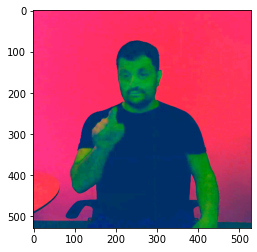

In [78]:
file_path = "../data/cam2/1/2022-04-25 13-29-56.mp4"

cap = cv2.VideoCapture(file_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, 50)
res, img = cap.read()
img = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
print(type(img), img.shape)
img = PIL.Image.fromarray(img)
# img = transforms.forward(img)
img = preprocess.forward(img)
print(type(img))

print(img.shape)
plt.imshow(img.permute(1, 2, 0))

In [79]:
file_path = "../data/cam2/1/2022-04-25 13-29-56.mp4"

cap = cv2.VideoCapture(file_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, 50)
res, img = cap.read()
img = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
img = PIL.Image.fromarray(img)
img = preprocess.forward(img)

dims = [1]
dims + list(img.shape)
img = torch.reshape(img, dims)
# print(img.shape)
out = my_model(img)
out.shape

RuntimeError: shape '[1]' is invalid for input of size 836352

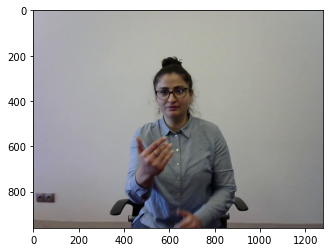

In [20]:
file_path = "../data/cam2/1/2022-05-26 11-15-10.mp4"

cap = cv2.VideoCapture(file_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, 50)
res, img = cap.read()
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = PIL.Image.fromarray(img)
plt.imshow(np.asarray(img))

In [21]:
from modules.temp_conv import TemporalConv

In [22]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [23]:
model.eval().to(device)

/home/toghrul/anaconda3/envs/sign-lang/lib/python3.9/site-packages/torch/cuda/__init__.py:146: UserWarning: 
NVIDIA RTX A5000 with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the NVIDIA RTX A5000 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 56, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(56, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(56, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=56, bias=False)
            (1): BatchNorm2d(56, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(56, 14, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(14, 56, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [24]:
import torchvision.models as models
from modules.temp_conv import TemporalConv

In [25]:
class SLRModel(nn.Model):
    def __init__(
        self, num_classes, c2d_type. conv_type, use_bn=False,
        hidden_size=1024, gloss_dict=None, loss_weights=None,
        weight_norm=True, share_classifier=True
    ):
    super(SLRModel, self).__init__()
    self.decoder = None
    self.loss = dict()
    self.criterion_init()
    self.num_classes = num_classes
    self.loss_weights = loss_weights
    self.conv2d = getattr(models, c2d_type)(pretrained=True)
    self.conv1d = TemporalConv(input_size=512,
                                   hidden_size=hidden_size,
                                   conv_type=conv_type,
                                   use_bn=use_bn,
                                   num_classes=num_classes)



    

SyntaxError: invalid syntax (3035282140.py, line 3)

In [ ]:
torch.cuda.device_count()

1

In [26]:
import torchvision
import torch.optim as optim

In [27]:
import os
import json
import cv2
import shutil

In [28]:
gloss_df

,gloss,glossStart,glossEnd,fileName,sentenceID,glossRange
0,MƏN,9.0,24.0,2022-07-18 16-41-51.mp4,70,15.0
1,EV,29.0,41.0,2022-07-18 16-41-51.mp4,70,12.0
2,YANMAQ,46.0,102.0,2022-07-18 16-41-51.mp4,70,56.0
3,EV,30.0,41.0,2022-07-20 14-09-03.mp4,70,11.0
4,YANMAQ,44.0,74.0,2022-07-20 14-09-03.mp4,70,30.0
...,...,...,...,...,...,...
9108,ALMIŞAM,104.0,139.0,2022-07-27 11-53-28.mp4,249,35.0
9109,OĞUL,44.0,61.0,2022-07-27 11-53-28.mp4,249,17.0
9110,ÜÇÜN,64.0,78.0,2022-07-27 11-53-28.mp4,249,14.0
9111,HƏDİYYƏ,81.0,97.0,2022-07-27 11-53-28.mp4,249,16.0


(array([ 23.,   4.,  17.,  15.,  22.,  30.,  36.,  45.,  56.,  61.,  82.,
         94.,  94.,  94., 102., 108., 103., 101., 104., 106., 112.,  96.,
         90.,  86.,  93.,  79.,  90.,  74.,  91.,  82., 108.,  99., 104.,
         97.,  91., 105., 110.,  97.,  95.,  87.,  98.,  81., 108., 107.,
         82.,  93.,  92.,  91., 106.,  97.]),
 array([ 0.  ,  0.98,  1.96,  2.94,  3.92,  4.9 ,  5.88,  6.86,  7.84,
         8.82,  9.8 , 10.78, 11.76, 12.74, 13.72, 14.7 , 15.68, 16.66,
        17.64, 18.62, 19.6 , 20.58, 21.56, 22.54, 23.52, 24.5 , 25.48,
        26.46, 27.44, 28.42, 29.4 , 30.38, 31.36, 32.34, 33.32, 34.3 ,
        35.28, 36.26, 37.24, 38.22, 39.2 , 40.18, 41.16, 42.14, 43.12,
        44.1 , 45.08, 46.06, 47.04, 48.02, 49.  ]),
 <BarContainer object of 50 artists>)

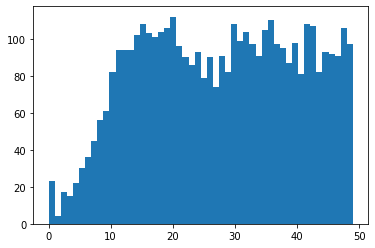

In [36]:
plt.hist(gloss_df[gloss_df.glossStart < 50]['glossStart'], bins=50)

In [ ]:
gloss_df.loc[0, 'glossStart']

9.0

In [ ]:
read_src = '../data/cam2'
write_src = '../data/gloss/cam2'

In [ ]:
cwd = os.path.dirname(os.path.abspath("tmp.ipynb"))
print(cwd)

/home/toghrul/SLR/sign-lang


In [ ]:
def video_to_frames(glossStart, glossEnd, video_path, size=None):
    """
    video_path -> str, path to video.
    size -> (int, int), width, height.
    """

    cap = cv2.VideoCapture(video_path)

    frames = []
    
    while True:
        res, frame = cap.read()
    
        if res:
            if size:
                frame = cv2.resize(frame, size)
            frames.append(frame)
        else:
            break

    cap.release()

    return frames[glossStart: glossEnd+1]

In [ ]:
def convert_frames_to_video(frames, path_out, size, fps=25):
    writer = cv2.VideoWriter(path_out, cv2.VideoWriter_fourcc(*'mp4v'), fps, size)

    for frame in frames:
        # writing to a image array
        writer.write(frame)
    writer.release()

In [ ]:
for gloss, df in gloss_df.groupby(by='gloss'):
    for i in range(len(df)):
        
        df.reset_index(drop=True, inplace=True)
        video_path = os.path.join(read_src, str(df.loc[i, 'sentenceID']), df.loc[i, 'fileName'])
        
        if os.path.exists(video_path):
            write_path = path_out = os.path.join(write_src, gloss)
            if not os.path.exists(write_path):
                os.mkdir(write_path)

            path_out = os.path.join(write_path, df.loc[i,'fileName'])
            
            frames = video_to_frames(int(df.loc[i, 'glossStart']),
                                        int(df.loc[i, 'glossEnd']),
                                        video_path,
            )

            size = frames[0].shape[:2][::-1]
            convert_frames_to_video(frames, path_out, size, fps=25)
            
            if os.path.exists(path_out):
                print(f">>> Created: {path_out}")
            else:
                print("sth wrong")
                break


Exists
57
>>> Created: ../data/gloss/cam2/AD/2022-07-16 11-23-12.mp4
Exists
62
>>> Created: ../data/gloss/cam2/AD/2022-07-13 14-27-01.mp4
Exists
45
>>> Created: ../data/gloss/cam2/AD/2022-07-20 16-22-17.mp4
Exists
58
>>> Created: ../data/gloss/cam2/AD/2022-08-01 12-42-31.mp4
Exists
56
>>> Created: ../data/gloss/cam2/AD/2022-05-24 15-41-33.mp4
Exists
25
>>> Created: ../data/gloss/cam2/AD/2022-07-22 13-28-59.mp4
Exists
95
>>> Created: ../data/gloss/cam2/AD/2022-05-25 13-19-19.mp4
Exists
52
>>> Created: ../data/gloss/cam2/AD/2022-05-26 11-15-10.mp4
Exists
56
>>> Created: ../data/gloss/cam2/AD/2022-07-02 17-35-35.mp4
Exists
72
>>> Created: ../data/gloss/cam2/AD/2022-07-02 17-35-35.mp4
Exists
97
>>> Created: ../data/gloss/cam2/AD/2022-04-26 12-57-16.mp4
Exists
64
>>> Created: ../data/gloss/cam2/AD/2022-07-15 14-49-32.mp4
Exists
97
>>> Created: ../data/gloss/cam2/AD/2022-05-24 16-23-20.mp4
Exists
63
>>> Created: ../data/gloss/cam2/AD/2022-07-29 18-42-40.mp4
Exists
47
>>> Created: ../data/glo

In [31]:
int(11/2)

5

In [32]:
11//2

5

In [33]:
gloss_df.glossStart.median()

54.0